In [26]:
from loaddata import *
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from nltk import ngrams

import numpy as np
import math

In [2]:
# Load scenario 10 data
df = load_data('datasets/capture20110818.pcap.netflow.labeled')
# Remove background flows
df = df.loc[df['Label'] != 'Background']
# Reset index
df.reset_index(drop=True)
df.head()

,Date_flow,start,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Label,src_ip,src_port,dst_ip,dst_port
20,2011-08-18,10:19:13.347,4.985,TCP,PA_,0,91,86277,1,LEGITIMATE,147.32.80.13,80,147.32.85.88,56949
51,2011-08-18,10:19:13.392,0.000,TCP,A_,0,1,66,1,LEGITIMATE,147.32.86.110,48102,74.125.232.214,443
57,2011-08-18,10:19:13.411,4.921,TCP,A_,0,49,3234,1,LEGITIMATE,147.32.85.88,56949,147.32.80.13,80
73,2011-08-18,10:19:13.460,4.742,TCP,A_,0,118,7080,1,LEGITIMATE,147.32.84.59,2768,74.125.108.208,80
75,2011-08-18,10:19:13.486,0.000,TCP,A_,0,1,60,1,LEGITIMATE,147.32.84.59,56058,74.125.232.215,443


---------- Netflows from infected hosts statistics----------
              Durat      Tos       Packets          Bytes    Flows
count  19889.000000  19889.0  19889.000000   19889.000000  19889.0
mean       0.551279      0.0     15.838705   14104.124943      1.0
std        1.436274      0.0    102.152312   84291.197116      0.0
min        0.000000      0.0      1.000000      60.000000      1.0
25%        0.000000      0.0      1.000000    1066.000000      1.0
50%        0.000000      0.0      1.000000    1066.000000      1.0
75%        0.000000      0.0      1.000000    1066.000000      1.0
max        4.999000      0.0   1000.000000  787188.000000      1.0
---------- Netflows from normal hosts statistics ----------
              Durat      Tos       Packets         Bytes    Flows
count  39925.000000  39925.0  39925.000000  3.992500e+04  39925.0
mean       0.356154      0.0     11.064596  8.127969e+03      1.0
std        1.045342      0.0    119.777720  1.236821e+05      0.0
min        0

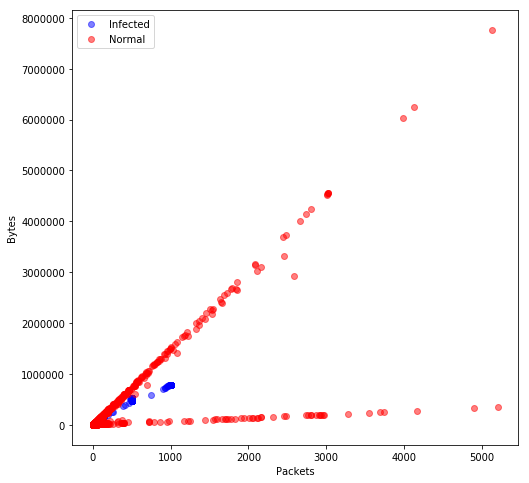

In [3]:
# Encode categorical features 
# labelencoder = LabelEncoder()
# df['Prot'] = labelencoder.fit_transform(df['Prot'])
# df['Flags'] = labelencoder.fit_transform(df['Flags'])

# Choose infected and normal hosts
infected_ip = '147.32.84.165'
normal_ip = ['147.32.84.170', '147.32.84.134', '147.32.84.164', '147.32.87.36', '147.32.80.9', '147.32.87.11']

# Separate infected and normal netflows
normal_df = df.loc[df['src_ip'].isin(normal_ip)]
infected_df = df.loc[df['src_ip'] == infected_ip]
normal_df.reset_index(drop=True)
infected_df.reset_index(drop=True)

print("---------- Netflows from infected hosts statistics----------")
print(infected_df.describe(include=[np.number]))
print("---------- Netflows from normal hosts statistics ----------")
print(normal_df.describe(include=[np.number]))

# Visualize features
plt.figure(figsize=(8,8))
plt.scatter(infected_df['Packets'], infected_df['Bytes'], c='blue', alpha=0.5, label='Infected')
plt.scatter(normal_df['Packets'], normal_df['Bytes'], c='red', alpha=0.5, label='Normal')
plt.xlabel("Packets")
plt.ylabel("Bytes")
# plt.boxplot(infected_df['Packets'])
plt.legend()
plt.show()


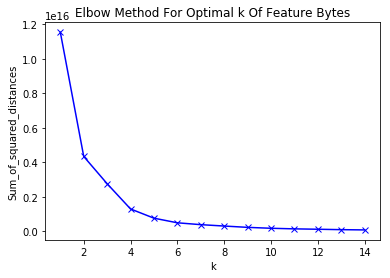

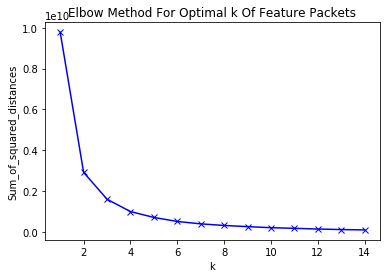

In [4]:
def elbow(feature):
  Sum_of_squared_distances = []
  K = range(1,15)
  for k in K:
      km = KMeans(n_clusters=k)
      km = km.fit(df[feature].values.reshape(-1,1))
      center = km.cluster_centers_
      Sum_of_squared_distances.append(km.inertia_)

  plt.plot(K, Sum_of_squared_distances, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Sum_of_squared_distances')
  plt.title('Elbow Method For Optimal k Of Feature %s' % feature)
  plt.savefig('elbow_%s' % feature)
  plt.show()
  
elbow('Bytes')
elbow('Packets')

In [5]:
# Function to get values at n-th percentiles from the given feature
# e.g. bins = 5, will return 20 40 60 80 100th percentiles
def get_percentile_values(bins, feature):
  percentile = []

  # Copy data to a list and sort it
  values = df[feature].tolist()
  values.sort()

  for i in range(1, bins + 1):
    percent = int((((100/bins) * i)/100) * len(values))
    percentile.append(values[percent - 1])

  print("The percentile of Feature %s with %d bins is %s" % (feature, bins, percentile))
  return percentile

# Map a value to n-th percentile
def encode_percentile(value, percentile):
  length = len(percentile)
  code = length - 1
  
  for i in range(0, length):
    if(value <= percentile[i]):
      code = i
      break
  return code

def netflow_encoding(feature_values, bins_value):
  spaceSize = np.prod(bins_value)
  code = 0
  
  for i in range(len(bins_value)):
    code += feature_values[i] * spaceSize / bins_value[i]
    spaceSize /= bins_value[i]
  
  return code

In [6]:
df['Bytes_code'] = 0
percentile = get_percentile_values(5, 'Bytes')
df['Bytes_code'] = df['Bytes'].apply(encode_percentile, args=[percentile])

df['Packets_code'] = 0
percentile = get_percentile_values(5, 'Packets')
df['Packets_code'] = df['Packets'].apply(encode_percentile, args=[percentile])


The percentile of Feature Bytes with 5 bins is [132, 1066, 1066, 2132, 24972468]
The percentile of Feature Packets with 5 bins is [1, 1, 2, 5, 16937]


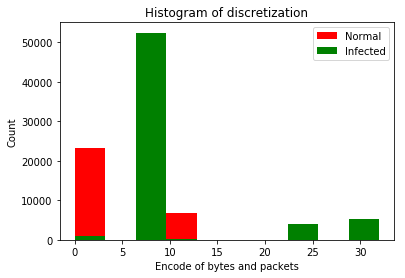

In [7]:
# Apply discretization to all hosts
discretize_df = df[['Bytes_code', 'Packets_code']]
result = discretize_df.apply(lambda x: netflow_encoding(x.tolist(), [5, 7]), axis = 1)

df['result'] = 0
df['result'] = result.values

# Separate flows from normal hosts and infected hosts
all_infected_ips = ['147.32.84.165', '147.32.84.191', '147.32.84.192']
infected_df = df.loc[df['src_ip'].isin(all_infected_ips)]
normal_df = df.loc[df['src_ip'].isin(normal_ip)]
normal_df.reset_index(drop=True)
infected_df.reset_index(drop=True)

# Visualize
plt.hist(normal_df['result'], color='r', label='Normal')
plt.hist(infected_df['result'], color='g', label='Infected')
plt.legend()
plt.gca().set(title='Histogram of discretization', xlabel='Encode of bytes and packets', ylabel='Count')
plt.show()

In [64]:
#Create sequential probabilistic model using ngrams using an infected host, and validate this model on all other hosts
def ngram_prob_model(training_data, test_data,sw_size, threshold):
    #Define the possible states
    states = range(0,35)
        
    #Create a list of all bigrams in the state sequence
    bi_grams = list(ngrams(training_data, 2))
    #Create a list of all possible bigrams
    comb_states = []
    for state_1 in states:
        for state_2 in states:
            pair = (state_1, state_2)
            comb_states.append(pair)
    #Create a from->to transition pair for each bigram in the state sequence
    comb_bi_grams = ngrams(bi_grams, 2)
    p_dict = {}
    p_dict_start = {}

    #Smoothe and initialize the transition matrix and init matrix
    for state in comb_states:
        p_dict[state] = {}
        p_dict_start[state] = 1
        for to_state in comb_states:
            p_dict[state][to_state] = 1

    #Add all starting states to init matrix
    total_init = 0
    for state in bi_grams:
        p_dict_start[state] = p_dict_start[state]+1
        total_init = total_init +1    
    total_init = total_init + len(comb_states)

    #Add all transition pairs to transition matrix
    for pair in comb_bi_grams:
        (src, dest)= pair
        p_dict[src][dest] = p_dict[src][dest]+1

    #Normalize both matrics
    for src in comb_states:
        p_dict_start[src] = p_dict_start[src]/total_init
        total_trans = 0
        for dest in comb_states:
            total_trans = total_trans + p_dict[src][dest]
        for dest in comb_states:
            p_dict[src][dest] = p_dict[src][dest]/total_trans
    
    infected_hosts = []
    #Iterate over each host in the test data to match profiles
    grouped = test_data.groupby(by='src_ip')
    for host, relevant_flows in grouped:
        #Get the discretionized data from the flows and create bigrams
        test_states = relevant_flows['result'].values
        test_bigrams = list(ngrams(test_states, 2))
        n = len(test_bigrams)  
        max_lkhd = 0
        #Iterate over all sliding windows and calculate the likelihood of the sequence in the sliding window 
        #according to the Markov matrics
        for i in range(0,n-sw_size):
            slc = test_bigrams[i:i+sw_size]
            p = p_dict_start[slc[0]]
            trans = ngrams(slc, 2)
            for transition in trans:
                (src, dst) = transition
                p = p * p_dict[src][dest] 
            #Determine the maximum likelihood for all sliding windows
            if(p> max_lkhd):
                max_lkhd = p 
        #If the maximum likelihood is higher than the threshold, mark the host as infected        
        if(max_lkhd>threshold):
            infected_hosts.append(host)
    return infected_hosts

#Determine the optimum values for the sliding window size and threshold parameters
def test_params(training_data, test_data, infected_hosts):
    #Determine ranges in which these values lie
    cand_t = 10.**(np.asarray(range(-70,-50))/2)
    cand_sw = range(9,12)
    tps = np.zeros((len(cand_t), len(cand_sw)))
    fps= np.zeros((len(cand_t), len(cand_sw)))
    
    best_params = (0,0)
    n_infect = len(infected_hosts)
    least_fps = len(test_data)
    t = 0
    #Iterate over all combinations for the parameter values
    for threshold in cand_t:
        sw = 0
        for sw_size in cand_sw:
            #Get the amount of true and false positives for the prob-model given the parametesr
            cand_infected = ngram_prob_model(training_data, test_data,sw_size, threshold)
            TP = 0
            FP = 0
            for host in cand_infected:
                if host in infected_hosts:
                    TP = TP +1
                else:
                    FP = FP+1
            tps[t][sw] = TP
            fps[t][sw] = FP
            
            #If all true positives are found, and the amount of false positives is lower than any of the previous iterations
            #Add the current values as best parameter values
            if TP == n_infect and FP < least_fps:
                least_fps = FP
                best_params = (threshold, sw_size)
            
            sw = sw+1
        t = t+1
    return best_params


In [65]:
#Get the training and test data
training_data = df[df['src_ip']==infected_ip]['result'].values
test_data = df[df['src_ip']!=infected_ip]
infected_hosts = ["147.32.84.191","147.32.84.192","147.32.84.193","147.32.84.204","147.32.84.205","147.32.84.206","147.32.84.207","147.32.84.208","147.32.84.209"]

#Call the sequential probability function with the best parameters 
(threshold, sw_size) = test_params(training_data, test_data, infected_hosts)
cand_infected = ngram_prob_model(training_data, test_data,sw_size, threshold)
TP = 0
FP = 0
for host in cand_infected:
    if host in infected_hosts:
        TP = TP +1
    else:
        FP = FP+1
FN = len(infected_hosts)- TP
TN = (len(test_data['src_ip'].unique())) - FP

#Calculate metrics

acc = (TP+TN)/(TP+FP+TN+FN) #Accuracy
recall = TP/(TP+FN) #Recall
specif = TN / (FP + TN) #Specificity
prec = TP/(TP+FP) #Precision
fp_rate = FP/(FP+TN) #False Positive Rate

print ('TP: '+ str(TP))
print ('FP: '+ str(FP))
print ('FN: '+ str(FN))
print ('TN: '+ str(TN))
print ('FP Rate : '+ str(fp_rate))
print('Accuracy:' + str(acc))
print('Recall:' + str(recall))
print('Specificity:' + str(specif))
print('Precision:' + str(prec))


TP: 9
FP: 34
FN: 0
TN: 487
FP Rate : 0.06525911708253358
Accuracy:0.9358490566037736
Recall:1.0
Specificity:0.9347408829174664
Precision:0.20930232558139536


In [63]:
sw_size

array([[268., 258., 232.],
       [268., 258., 222.],
       [268., 258., 213.],
       [268., 258., 186.],
       [268., 257., 156.],
       [268., 256.,  34.],
       [268., 245.,   0.],
       [268., 234.,   0.],
       [267., 225.,   0.],
       [267., 205.,   0.],
       [267., 178.,   0.],
       [267.,  43.,   0.],
       [254.,   0.,   0.],
       [249.,   0.,   0.],
       [235.,   0.,   0.],
       [216.,   0.,   0.],
       [190.,   0.,   0.],
       [137.,   0.,   0.],
       [ 19.,   0.,   0.],
       [  0.,   0.,   0.]])

In [56]:
np.asarray(range(-70,-50))/2

array([-35. , -34.5, -34. , -33.5, -33. , -32.5, -32. , -31.5, -31. ,
       -30.5, -30. , -29.5, -29. , -28.5, -28. , -27.5, -27. , -26.5,
       -26. , -25.5])